In [1]:
from torch.cuda.amp import GradScaler, autocast
import tensorflow as tf
from   tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import class_weight

import nlpaug.augmenter.word as naw
import random
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

sns.set(rc={'figure.figsize':(20,10)})

2023-06-11 22:24:17.338185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 22:24:17.918311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load train and test data
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")

print(train_data.head())

# Split train and test data into features and targets
train_features = train_data["lyrics"]
train_targets = train_data["most_common_genre"]

test_features = test_data["lyrics"]
test_targets = test_data["most_common_genre"]

                       id                                             lyrics  \
0  1FAmKoufyAXMfzPPs9bsjA  i tied my bandana took my pack from the floor ...   
1  3QvPEv8XjHa73iYhaienWw  i want to live on the moon never see a human a...   
2  5VPFATm85G3P04Q5g8yxqr  bitch you know you can t parallel park anyway ...   
3  7J2jCftItt7htcOUdcMnpt  graceless falling slipping in the cold with no...   
4  4cBPzVIbDIQx0LIyauFAy0  madame morse estate stood five hundred years p...   

       artist_name most_common_genre  \
0  Waylon Jennings           country   
1   Phantom Planet              rock   
2    Isaiah Rashad           hip-hop   
3     Matt Pond PA             indie   
4       Ariel Pink               pop   

                                          genre_list  
0  ['country', 'country', 'rock', 'outlaw', 'coun...  
1                                    ['pop', 'rock']  
2  ['hip-hop', 'rap', 'tennessee', 'hip-hop', 'un...  
3                                ['philly', 'indie']  
4  

In [3]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(train_features)

x_k_train = tokenizer.texts_to_sequences(train_features)
x_k_test = tokenizer.texts_to_sequences(test_features)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

categories=list(train_targets.unique())

#print(X_train[2])
print(x_k_train[2])

maxlen = 1000

x_k_train = pad_sequences(x_k_train, padding='post', maxlen=maxlen)
x_k_test = pad_sequences(x_k_test, padding='post', maxlen=maxlen)

def print_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

[151, 3, 28, 3, 22, 10, 7580, 1203, 852, 17, 22, 10, 23, 36, 724, 50, 27, 17, 22, 23, 2, 1416, 58, 34, 128, 132, 15, 20, 62, 9, 1182, 252, 1, 16, 62, 36, 724, 50, 58, 41, 253, 45, 3, 220, 4, 41, 253, 211, 3, 42, 293, 293, 293, 17, 22, 10, 23, 36, 724, 50, 27, 17, 22, 23, 2, 1416, 58, 34, 128, 132, 15, 20, 62, 9, 1182, 252, 1, 16, 62, 36, 724, 50, 58, 41, 253, 45, 3, 220, 4, 41, 253, 211, 3, 42, 293, 293, 293, 65, 37, 9, 595, 1081, 900, 4, 9, 976, 51, 6, 172, 50, 139, 51, 6, 172, 50, 403, 3, 1683, 1185, 92, 8, 76, 3, 84, 10627, 71, 34, 11, 18, 1327, 40, 7, 76, 3, 170, 10627, 71, 34, 11, 18, 217, 1, 80, 178, 98, 6, 371, 1, 22, 10, 45, 31, 15, 9, 226, 35, 36, 209, 5, 49, 4, 13, 11, 6, 143, 50, 162, 41, 253, 33, 3, 37, 3, 383, 41, 119, 10, 410, 3, 37, 3, 167, 46, 3, 251, 21, 6, 861, 13, 11, 2, 220, 50, 27, 17, 22, 23, 2, 1416, 58, 34, 128, 132, 15, 20, 62, 9, 1182, 252, 1, 16, 62, 36, 724, 50, 58, 41, 253, 45, 3, 220, 4, 41, 253, 211, 3, 42, 293, 293, 293, 17, 22, 10, 23, 36, 724, 50, 27, 

In [4]:
y_k_train = pd.get_dummies(train_targets)
y_k_test = pd.get_dummies(test_targets)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 50)          2881300   
                                                                 
 dropout_8 (Dropout)         (None, None, 50)          0         
                                                                 
 global_average_pooling1d_3   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 1024)              52224     
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 10)                10250     
                                                      

c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bruno\.conda\envs\my_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


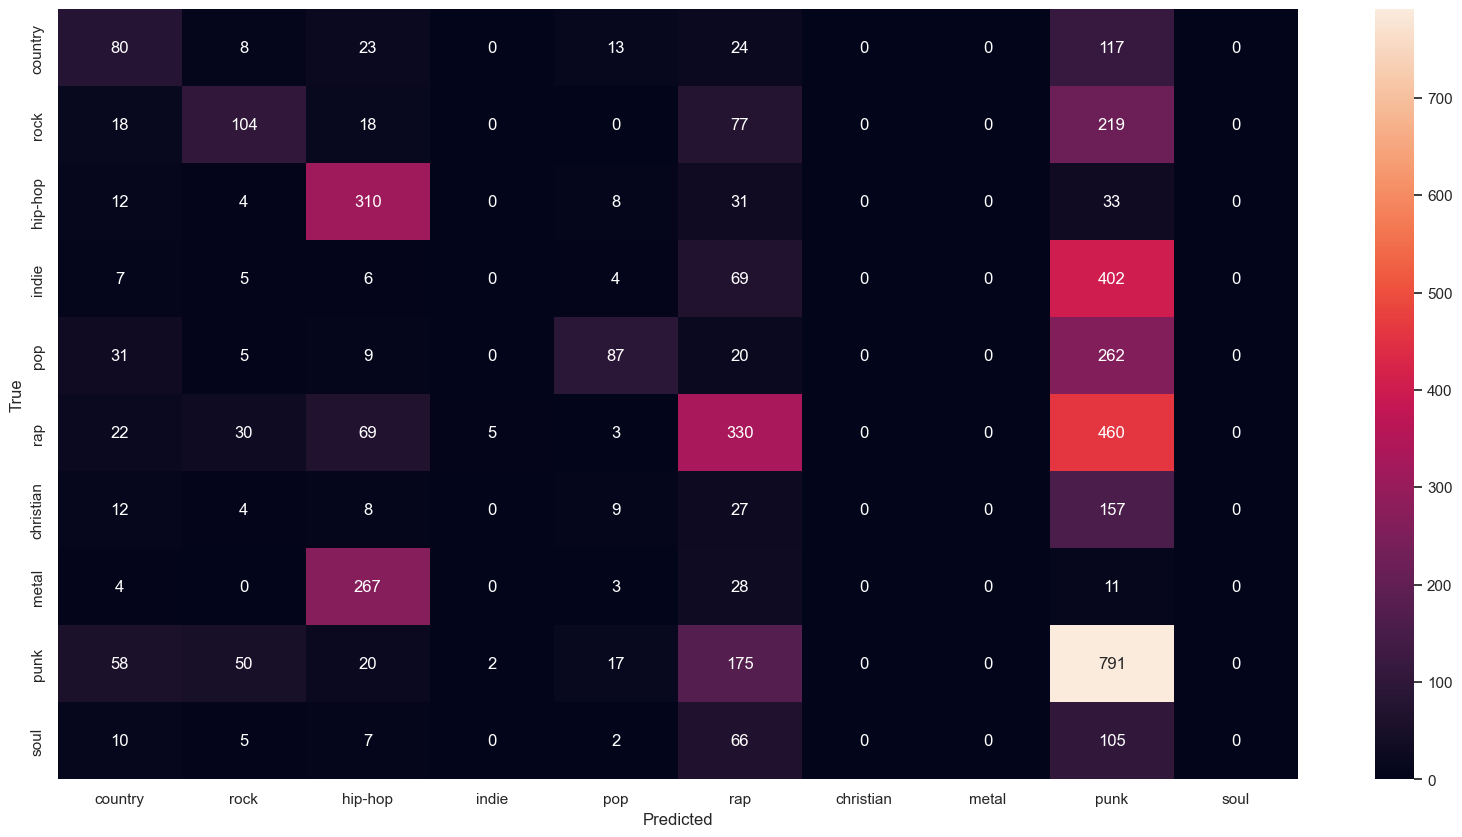

In [8]:
#initializer ='random_uniform'
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(1024, kernel_initializer='glorot_uniform', activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense( len(categories), activation=tf.nn.sigmoid))
model.add(keras.layers.Softmax())
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
import tensorflow as tf
with tf.device('/gpu:0'):
    history = model.fit(x_k_train, y_k_train, epochs=200, batch_size=512, validation_data=(x_k_test, y_k_test), verbose=1, callbacks=[callback])

y_prediction = model.predict(x_k_test)
y_pred_classes = np.argmax(y_prediction, axis=1)
y_test_classes = np.argmax(y_k_test.to_numpy(), axis=1)

print_report(y_test_classes, y_pred_classes)

In [5]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50, input_length=maxlen))
model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1024, kernel_initializer='glorot_uniform', activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense( len(categories), activation=tf.nn.sigmoid))
model.add(keras.layers.Softmax())
model.summary()


callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_k_train, y_k_train, epochs=500, batch_size=512, validation_data=(x_k_test, y_k_test), verbose=1, callbacks=[callback])

y_prediction = model.predict(x_k_test)
y_pred_classes = np.argmax(y_prediction, axis=1)
y_test_classes = np.argmax(y_k_test.to_numpy(), axis=1)

print_report(y_test_classes, y_pred_classes)

2023-06-11 22:24:38.925441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 22:24:38.950209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 22:24:38.950322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          2881300   
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          32128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 498, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 63744)             0         
                                                                 
 dropout (Dropout)           (None, 63744)             0         
                                                                 
 dense (Dense)               (None, 1024)              65274880  
                                                        

s-bus-pci#L344-L355
2023-06-11 22:24:38.951355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 22:24:38.951423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 22:24:40.371209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

UnimplementedError: Graph execution error:

Detected at node 'sequential/conv1d/Conv1D' defined at (most recent call last):
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_42488/4277640217.py", line 17, in <module>
      history = model.fit(x_k_train, y_k_train, epochs=500, batch_size=512, validation_data=(x_k_test, y_k_test), verbose=1, callbacks=[callback])
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/media/bruno/0d2f61d2-2b9c-4043-9a46-8e4dfe74fc95/bruno/anaconda3/envs/nlp-mc1/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/conv1d/Conv1D'
DNN library is not found.
	 [[{{node sequential/conv1d/Conv1D}}]] [Op:__inference_train_function_1320]